In [14]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors
from rasterio.plot import show
import rasterio.warp
from rasterio.crs import CRS
from rasterio.enums import Resampling
import sys
from pathlib import Path
import json
import h3
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely as shp
from shapely.geometry import mapping, shape
from collections import Counter
import pyproj
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Point
import contextily as cx

In [8]:
def count_occurances_break_tie(l):
    # given a list, return the most frequent item in the list
    # in the event of a tie, choose randomly
    c=Counter(l)
    # get frequency of top 2 items
    freq = c.most_common(2)

    if len(freq)==1:
        return freq[0][0]
    
    # check for ties
    else:
        if freq[0][1] != freq[1][1]:
            return freq[0][0]
        else:
            #print("tie for most common!")
            return np.random.choice([freq[0][0],freq[1][0]])

In [9]:
'''
label meanings:
01 : MSZ, open spaces, low vegetation surfaces NDVI <= 0.3
02 : MSZ, open spaces, medium vegetation surfaces 0.3 < NDVI <=0.5
03 : MSZ, open spaces, high vegetation surfaces NDVI > 0.5
04 : MSZ, open spaces, water surfaces LAND < 0.5
05 : MSZ, open spaces, road surfaces
11 : MSZ, built spaces, residential, building height <= 3m
12 : MSZ, built spaces, residential, 3m < building height <= 6m
13 : MSZ, built spaces, residential, 6m < building height <= 15m
14 : MSZ, built spaces, residential, 15m < building height <= 30m
15 : MSZ, built spaces, residential, building height > 30m
21 : MSZ, built spaces, non-residential, building height <= 3m
22 : MSZ, built spaces, non-residential, 3m < building height <= 6m
23 : MSZ, built spaces, non-residential, 6m < building height <= 15m
24 : MSZ, built spaces, non-residential, 15m < building height <= 30m
25 : MSZ, built spaces, non-residential, building height > 30m
''';

In [10]:
# reproject bounding box
# Define the point coordinates in the source CRS
# paste csv bounding box from this website https://boundingbox.klokantech.com/
bbox = [12.3999, 55.6059, 12.7456, 55.7652] # [xmin, ymin, xmax, ymax]

# Define the source and destination coordinate reference systems
transformer = pyproj.Transformer.from_crs('EPSG:4326','ESRI:54009')

# Reproject the point to the destination CRS
xmin, ymin = transformer.transform(bbox[1], bbox[0])
xmax, ymax = transformer.transform(bbox[3], bbox[2])


# Print the reprojected coordinates
print(f'xmin: {xmin}\nymin: {ymin}\nxmax: {xmax}\nymax: {ymax}')

xmin: 869130.4532188048
ymin: 6447260.833358239
xmax: 891054.3840504269
ymax: 6463158.24367017


In [11]:
# Open the raster file
fp= '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19.tif'
out_file = '../resources/copenhagen_subset.tif'

with rasterio.open(fp) as src:

    # Get the raster size
    rows, cols = src.shape

    # Specify the subset region in pixel coordinates
    # convert bounds to other crs: https://epsg.io/transform#s_srs=4326&t_srs=54009&x=NaN&y=NaN
    window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)

    # Read the subset region from the raster
    subset = src.read(1, window=window)

    # Create a new raster file for the subset
    profile = src.profile
    profile.update({
        'width': window.width,
        'height': window.height,
        'transform': src.window_transform(window)
    })
    with rasterio.open(out_file, 'w', **profile) as dst:

        # Write the subset to the new raster file
        dst.write(subset, 1)

In [15]:
dst_crs = 'EPSG:4326'
reprojected_file = '../resources/reprojected_copenhagen.tif'
H3_RES = 12
urban_map = dict()

with rasterio.open(out_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    print(src.crs)
    print(src.width)
    print(src.height)
    print(kwargs)

    # band
    with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
        b, trans = reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
        
with rasterio.open(reprojected_file) as dst_band:
    b = dst_band.read(1)

height = b.shape[-2]
width = b.shape[-1]
ys, xs = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(trans, xs, ys)
xs= np.array(xs).flatten()
ys = np.array(ys).flatten()

rel_vals = [11,12,13,14,15,21,22,23,24,25]

# https://ghsl.jrc.ec.europa.eu/ghs_buC2022.php for value descriptions
for x,y, val in zip(ys, xs, b.flatten()):
    #if val in rel_vals:
    try:
        urban_map[h3.geo_to_h3(x,y, resolution=H3_RES)].append(val)
    except:
        urban_map[h3.geo_to_h3(x,y, resolution=H3_RES)]=[val]

# break ties for most common codes for an h3 index
# turn into dataframe with columns specified for csv export
df = pd.DataFrame([(key, count_occurances_break_tie(val)) for key, val in urban_map.items()],
              columns=['h3_index','ghsl_code'])

df.to_csv('../resources/ghsl_h3_codes.csv', index=False)
        

ESRI:54009
2192
1589
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2900, 'height': 1336, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(0.00011918249700066545, 0.0, 12.399914887177163,
       0.0, -0.00011918249700066545, 55.76519999999999)}


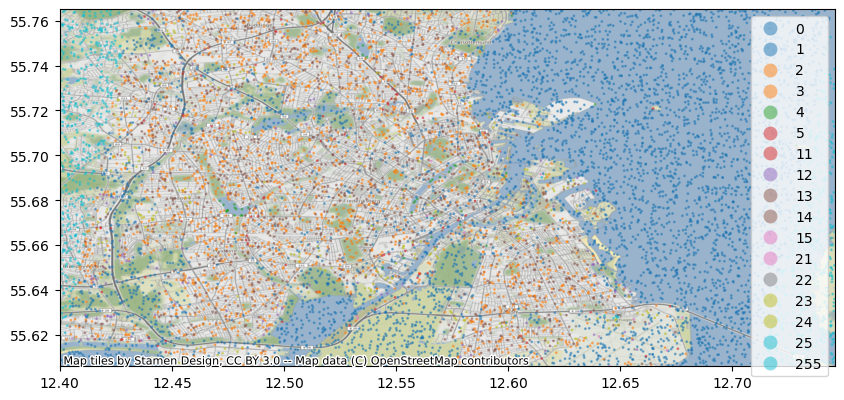

In [16]:
sample_df = df.sample(10000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='ghsl_code', categorical=True, legend=True, markersize=1, alpha=0.5)
#gdf.plot(ax=ax, column='ghsl_code',cmap='Reds', markersize=1)
plt.xlim(bbox[0],bbox[2])
plt.ylim(bbox[1],bbox[3])
#plt.xlim(-80,-76)
#plt.ylim(23,26)
cx.add_basemap(ax = ax, crs="EPSG:4326") #, source=cx.providers.CartoDB.Positron\